# Introduction to Time Series Forecasting Project Using XGBoost

In this notebook we'll leverage the predictive capabilities of XGBoost in time series forecasting. By systematically executing each phase of the project, from data preparation through to model assessment and projection, the objective is to construct a reliable model that offers accurate sales predictions, thereby providing useful insights for informed decision-making in business contexts.

## XGBoost

XGBoost stands for “Extreme Gradient Boosting” and is a machine learning algorithm that is part of the gradient boosting family. Fundamentally, it operates on the principle of boosting, which involves sequentially combining multiple weak predictive models to form a strong predictor. In the case of XGBoost, these weak models are typically decision trees.

A key aspect of XGBoost is its ability to handle missing data and provide a framework for both linear and tree learners. It also employs techniques like parallel processing and efficient memory usage, which make it computationally efficient, particularly for large datasets. The algorithm's performance and efficiency, coupled with its ability to be finely tuned through hyperparameter optimization, make it a powerful tool for predictive modeling in various machine learning applications.

## Decision Trees

A decision tree is a versatile machine learning model used for both classification and regression tasks. It represents a series of decision rules that, when followed from root to leaf, lead to a prediction based on the input features. At each node in the tree, the data is split according to a specific criterion, dividing the dataset into increasingly homogenous subsets. This structure makes decision trees particularly intuitive and easy to interpret, as they visually mimic human decision-making processes.

To train a decision tree, an algorithm first selects the best feature to split the data at each node. This selection is typically based on criteria such as Gini impurity or information gain, which measure how well a particular split will separate the data into distinct classes or groups. The process continues recursively, creating branches for each split, until a stopping criterion is met, such as reaching a maximum depth or a minimum number of samples in a leaf. This method allows the tree to learn from the training data by constructing a hierarchy of decision rules that can accurately classify or predict the target variable.

## Random Forests

A Random Forest model works by constructing a multitude of decision trees during training and outputting the class that is the mode of the classes (in classification) or mean prediction (in regression) of the individual trees.

The algorithm begins by creating multiple decision trees from randomly selected subsets of the training dataset. This process, known as bootstrapping, involves sampling data with replacement, resulting in different trees seeing different parts of the dataset. Additionally, when splitting nodes during the construction of trees, Random Forest randomly selects a subset of the features rather than using the most significant feature. This randomness helps in creating a diverse set of trees and reduces the correlation between them, enhancing the overall prediction accuracy and reducing overfitting.

## Gradient Boosting

Boosting is a machine learning ensemble technique that improves the accuracy of models by combining multiple weak learners to form a strong learner. A weak learner is a model that is only slightly correlated with the true classification. In boosting, these learners are trained sequentially, with each one focusing on the errors made by the previous ones, thereby incrementally improving the model's performance.

Gradient boosting, a specific type of boosting, refines this process further. It builds the model in a stage-wise fashion, with each new model being added to correct the errors of the sum of the previously built models. The key idea in gradient boosting is to use the gradient descent algorithm to minimize the loss function, which measures the difference between the actual and predicted values. At each step, a new weak learner is trained with respect to the error gradient of the whole ensemble learned so far.

In both boosting and gradient boosting, the final model is a weighted sum of the weak learners, with more weight given to those that perform better. These techniques are known for their high accuracy and effectiveness, particularly in scenarios where the dataset is imbalanced or in the presence of significant noise. They are widely used in various machine learning tasks, including classification, regression, and ranking.

## Mathematical Foundations

The objective function in XGBoost combines a loss function and a regularization term, defined as:

$$
\text{Obj}(\Theta) = L(\Theta) + \Omega(\Theta)
$$

Where $ L(\Theta) $ is the loss function (measuring the prediction error) and $ \Omega(\Theta) $ is the regularization term (controlling model complexity).

The regularization term, unique to its formulation, is given by:

$$
\Omega(f) = \gamma T + \frac{1}{2} \lambda \|w\|^2
$$

Here, $ T $ is the number of leaves in a tree, $ w $ are the leaf weights, $ \gamma $ represents the complexity cost per tree, and $ \lambda $ is the L2 regularization term on the weights.

### Tree Ensemble Model
The model in XGBoost is an ensemble of additive functions (trees), represented as:

$$
\hat{y}_i = \sum_{k=1}^{K} f_k(x_i), \quad f_k \in F
$$

Where $ F $ is the space of regression trees, $ x_i $ are the input features, $ \hat{y}_i $ is the predicted output, and $ f_k $ denotes an individual tree.

Each tree is built by iteratively adding branches, optimizing the feature splits based on the gain, which is calculated using [gradient and Hessian statistics](https://en.wikipedia.org/wiki/Hessian_matrix). Post-training, XGBoost assigns an importance score to each feature based on the number of times a feature is used in splits and the associated gain.


# Imports

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# Data Preparation

## Data Loading

As in the last notebook, we'll focus on forecasting sales data specifically for Store 2

In [2]:
root_data_folder = "data"
raw_data_folder = os.path.join(root_data_folder, "raw")
processed_data_folder = os.path.join(root_data_folder, "processed")

In [3]:
stores_sales_df = pd.read_parquet(
    os.path.join(processed_data_folder, "stores-sales.parquet")
)

sample_store_data = (
    stores_sales_df[stores_sales_df["Store"] == 2]
)[["Sales", "StateHoliday", "Promo"]]

sample_store_data

,Sales,StateHoliday,Promo
Date,,,
2013-01-01,0,a,0
2013-01-02,4422,0,0
2013-01-03,4159,0,0
2013-01-04,4484,0,0
2013-01-05,2342,0,0
...,...,...,...
2015-07-27,6627,0,1
2015-07-28,5671,0,1
2015-07-29,6402,0,1


## Feature Engineering

We'll again aggregate data into weekly total, in the same way we did in the last notebooks. The same must be done with the `StateHoliday` and `Promo` features.

In [4]:
weekly_features = sample_store_data["Sales"].resample("W").sum().reset_index()

weekly_features["StateHoliday"] = (
    sample_store_data["StateHoliday"]
        .map({"0": 0, "a": 1, "b": 2, "c": 3})
        .resample("W")
        .max()
        .reset_index(drop=True)
)

weekly_features["Promo"] = (
    sample_store_data["Promo"]
        .resample("W")
        .max()
        .reset_index(drop=True)
)

weekly_features = weekly_features.set_index("Date")

weekly_features

,Sales,StateHoliday,Promo
Date,,,
2013-01-06,15407,1,0
2013-01-13,32914,0,1
2013-01-20,21081,0,0
2013-01-27,29973,0,1
2013-02-03,23297,0,0
...,...,...,...
2015-07-05,39757,0,1
2015-07-12,25264,0,0
2015-07-19,32399,0,1


### Time-related Features

We'll add new columns to our dataframe for the year, month and week of the year.

In [5]:
weekly_features["Year"] = weekly_features.index.year
weekly_features["Month"] = weekly_features.index.month
weekly_features["WeekOfYear"] = weekly_features.index.isocalendar().week

### Data Transformation

To work better with our model, we'll apply two transformations to our data:
- Standardize the `Sales` feature to make our model less sensitive to the scale of data.
- Apply One-Hot Encoding to the `StateHoliday` feature.

In [6]:
sales_transform = StandardScaler()

weekly_features["Sales"] = sales_transform.fit_transform(weekly_features[["Sales"]]).squeeze()
weekly_features = pd.get_dummies(weekly_features, columns=["StateHoliday"])
weekly_features

,Sales,Promo,Year,Month,WeekOfYear,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3
Date,,,,,,,,,
2013-01-06,-2.175661,0,2013,1,1,False,True,False,False
2013-01-13,0.674840,1,2013,1,2,True,False,False,False
2013-01-20,-1.251817,0,2013,1,3,True,False,False,False
2013-01-27,0.195984,1,2013,1,4,True,False,False,False
2013-02-03,-0.891006,0,2013,2,5,True,False,False,False
...,...,...,...,...,...,...,...,...,...
2015-07-05,1.789021,1,2015,7,27,True,False,False,False
2015-07-12,-0.570738,0,2015,7,28,True,False,False,False
2015-07-19,0.590987,1,2015,7,29,True,False,False,False


### Lag Features

Now we'll create columns for the last 3 weeks sales data.

In [7]:
weekly_features["Sales_Lag1"] = weekly_features["Sales"].shift(1)
weekly_features["Sales_Lag2"] = weekly_features["Sales"].shift(2)

### Rolling mean

We'll also create a rolling average of the last 4 weeks of sales.

In [8]:
weekly_features["Sales_4Week_Avg"] = weekly_features["Sales"].rolling(window=2).mean()
weekly_features

,Sales,Promo,Year,Month,WeekOfYear,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,Sales_Lag1,Sales_Lag2,Sales_4Week_Avg
Date,,,,,,,,,,,,
2013-01-06,-2.175661,0,2013,1,1,False,True,False,False,NaN,NaN,NaN
2013-01-13,0.674840,1,2013,1,2,True,False,False,False,-2.175661,NaN,-0.750411
2013-01-20,-1.251817,0,2013,1,3,True,False,False,False,0.674840,-2.175661,-0.288489
2013-01-27,0.195984,1,2013,1,4,True,False,False,False,-1.251817,0.674840,-0.527916
2013-02-03,-0.891006,0,2013,2,5,True,False,False,False,0.195984,-1.251817,-0.347511
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-05,1.789021,1,2015,7,27,True,False,False,False,-0.874073,0.912395,0.457474
2015-07-12,-0.570738,0,2015,7,28,True,False,False,False,1.789021,-0.874073,0.609142
2015-07-19,0.590987,1,2015,7,29,True,False,False,False,-0.570738,1.789021,0.010124


We'll drop rows os missing values, as we don't need them.

In [9]:
weekly_features = weekly_features.dropna()
weekly_features

,Sales,Promo,Year,Month,WeekOfYear,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,Sales_Lag1,Sales_Lag2,Sales_4Week_Avg
Date,,,,,,,,,,,,
2013-01-20,-1.251817,0,2013,1,3,True,False,False,False,0.674840,-2.175661,-0.288489
2013-01-27,0.195984,1,2013,1,4,True,False,False,False,-1.251817,0.674840,-0.527916
2013-02-03,-0.891006,0,2013,2,5,True,False,False,False,0.195984,-1.251817,-0.347511
2013-02-10,0.525370,1,2013,2,6,True,False,False,False,-0.891006,0.195984,-0.182818
2013-02-17,-0.788918,0,2013,2,7,True,False,False,False,0.525370,-0.891006,-0.131774
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-05,1.789021,1,2015,7,27,True,False,False,False,-0.874073,0.912395,0.457474
2015-07-12,-0.570738,0,2015,7,28,True,False,False,False,1.789021,-0.874073,0.609142
2015-07-19,0.590987,1,2015,7,29,True,False,False,False,-0.570738,1.789021,0.010124


### Data Split

Again, we'll collect the 20% more recent data for validation and the reamaining will be used for training.

In [10]:
data_len = len(weekly_features.index)
test_len = int(data_len * 0.2)

train_df = weekly_features.iloc[:-test_len]
test_df = weekly_features.iloc[-test_len:]

display(train_df)
display(test_df)

,Sales,Promo,Year,Month,WeekOfYear,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,Sales_Lag1,Sales_Lag2,Sales_4Week_Avg
Date,,,,,,,,,,,,
2013-01-20,-1.251817,0,2013,1,3,True,False,False,False,0.674840,-2.175661,-0.288489
2013-01-27,0.195984,1,2013,1,4,True,False,False,False,-1.251817,0.674840,-0.527916
2013-02-03,-0.891006,0,2013,2,5,True,False,False,False,0.195984,-1.251817,-0.347511
2013-02-10,0.525370,1,2013,2,6,True,False,False,False,-0.891006,0.195984,-0.182818
2013-02-17,-0.788918,0,2013,2,7,True,False,False,False,0.525370,-0.891006,-0.131774
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-04,-1.256864,0,2015,1,1,True,False,False,False,-0.946691,3.379779,-1.101778
2015-01-11,0.685749,1,2015,1,2,True,False,False,False,-1.256864,-0.946691,-0.285558
2015-01-18,0.883576,1,2015,1,3,True,False,False,False,0.685749,-1.256864,0.784662


,Sales,Promo,Year,Month,WeekOfYear,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,Sales_Lag1,Sales_Lag2,Sales_4Week_Avg
Date,,,,,,,,,,,,
2015-02-08,0.895136,1,2015,2,6,True,False,False,False,0.360270,-1.090787,0.627703
2015-02-15,-0.886447,0,2015,2,7,True,False,False,False,0.895136,0.360270,0.004344
2015-02-22,0.744690,1,2015,2,8,True,False,False,False,-0.886447,0.895136,-0.070879
2015-03-01,-0.916081,0,2015,3,9,True,False,False,False,0.744690,-0.886447,-0.085696
2015-03-08,0.821541,1,2015,3,10,True,False,False,False,-0.916081,0.744690,-0.047270
2015-03-15,-0.889052,0,2015,3,11,True,False,False,False,0.821541,-0.916081,-0.033756
2015-03-22,0.870876,1,2015,3,12,True,False,False,False,-0.889052,0.821541,-0.009088
2015-03-29,-0.696436,0,2015,3,13,True,False,False,False,0.870876,-0.889052,0.087220
2015-04-05,1.165418,1,2015,4,14,False,False,True,False,-0.696436,0.870876,0.234491


We'll also isolate the target features (Sales) from the independent features (the remaining features).

In [11]:
X_train, y_train = train_df.drop("Sales", axis="columns"), train_df[["Sales"]]
X_test, y_test = test_df.drop("Sales", axis="columns"), test_df[["Sales"]]

# Model Building

We'll create the simplest XGBoost model, with all parameters set to their default values. Given our current dataset size, this model is supposed to fit the data pretty well, even with no parameter optimization.

In [12]:
xgbr_regressor = XGBRegressor()

As usual, we'll train the model using the train set only, leaving the test set for validation.

In [13]:
xgbr_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Now we can get the predictions for both train and test features.

In [14]:
train_predictions = pd.DataFrame()
train_predictions.index = X_train.index
train_predictions["True Sales"] = sales_transform.inverse_transform(train_df[["Sales"]]).squeeze()
train_predictions["Predicted Sales"] = (
    sales_transform.inverse_transform((xgbr_regressor.predict(X_train))[np.newaxis, :]).squeeze()
)

test_predictions = pd.DataFrame()
test_predictions.index = X_test.index
test_predictions["True Sales"] = sales_transform.inverse_transform(test_df[["Sales"]]).squeeze()
test_predictions["Predicted Sales"] = (
    sales_transform.inverse_transform(xgbr_regressor.predict(X_test)[np.newaxis, :]).squeeze()
)

display(train_predictions)
display(test_predictions)

,True Sales,Predicted Sales
Date,,
2013-01-20,21081.0,21088.056641
2013-01-27,29973.0,29977.769531
2013-02-03,23297.0,23285.269531
2013-02-10,31996.0,31996.062500
2013-02-17,23924.0,23927.490234
...,...,...
2015-01-04,21050.0,21058.437500
2015-01-11,32981.0,32983.628906
2015-01-18,34196.0,34195.914062


,True Sales,Predicted Sales
Date,,
2015-02-08,34267.0,34493.640625
2015-02-15,23325.0,25016.375000
2015-02-22,33343.0,33927.027344
2015-03-01,23143.0,23130.695312
2015-03-08,33815.0,33929.609375
2015-03-15,23309.0,23516.017578
2015-03-22,34118.0,34240.964844
2015-03-29,24492.0,24491.582031
2015-04-05,35927.0,34802.464844


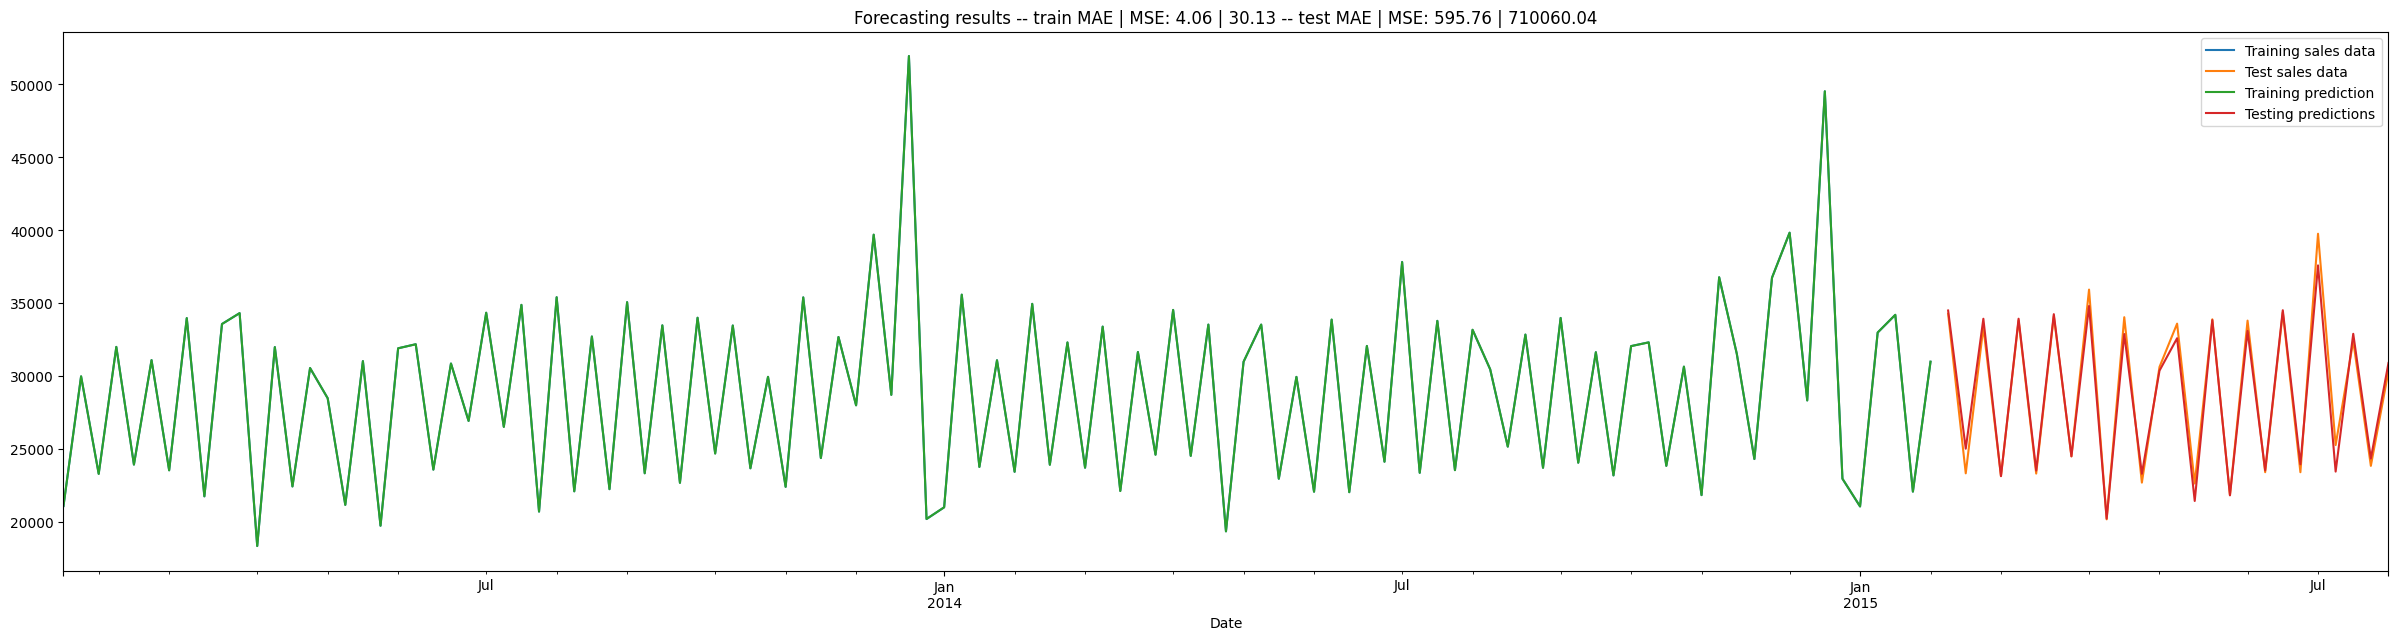

In [15]:
train_mae = mean_absolute_error(train_predictions["True Sales"], train_predictions["Predicted Sales"])
train_mse = mean_squared_error(train_predictions["True Sales"], train_predictions["Predicted Sales"])

test_mae = mean_absolute_error(test_predictions["True Sales"], test_predictions["Predicted Sales"])
test_mse = mean_squared_error(test_predictions["True Sales"], test_predictions["Predicted Sales"])

ax = train_predictions["True Sales"].plot(label="Training sales data", kind="line", figsize=(30, 7))
test_predictions["True Sales"].plot(label="Test sales data", kind="line", ax=ax)

train_predictions["Predicted Sales"].plot(label="Training prediction", kind="line", ax=ax)
test_predictions["Predicted Sales"].plot(label="Testing predictions", kind="line", ax=ax)

plt.title(f"Forecasting results -- train MAE | MSE: {train_mae:.2f} | {train_mse:.2f} -- test MAE | MSE: {test_mae:.2f} | {test_mse:.2f}")

plt.legend();

Here are some conclusions and observations that can be made:
- The model seems to fit the training data well. The predictions on the training set appear to follow the actual sales data trends closely. This indicates that the model has learned the patterns within the training data effectively.
- For the test data, the forecasted values are tracking the actual sales data. While differences in the amplitude of the predicted and actual values indicates that the model isn't capturing the full variability of the test data, model successfully captures the oscillation pattern.
- The model is picking up on this seasonality since the predictions show a similar cyclical pattern.
- Since the model predictions on the training data are very close to the actual values, there's a possibility of overfitting. If the model is too complex and has learned the noise in the training data rather than the underlying pattern, it might not perform as well on the test set or future unseen data.